# EDA and Data Preparation for Stress Calculation

First thing we are doing is handling the vanishing vehicles! that needs the primary attention as it is the motivation for this project

### service date & local midnight ➜ UTC epoch

In [6]:
from datetime import datetime
from zoneinfo import ZoneInfo

tz_lon = ZoneInfo("Europe/London")          # honours BST/GMT automatically
service_date = datetime(2025, 7, 14)        # yyyy, m, d (NO tz yet)
svc_mid_local = service_date.replace(tzinfo=tz_lon)
svc_mid_utc   = int(svc_mid_local.timestamp())

print("Local midnight:", svc_mid_local)     # 2025-07-14 00:00:00+01:00
print("UTC  epoch  :", svc_mid_utc)         # 1752457200


Local midnight: 2025-07-14 00:00:00+01:00
UTC  epoch  : 1752447600


### Load stop_times.txt and get the scheduled end of every trip

In [7]:
import pandas as pd

st = pd.read_csv("../gtfs_static/stop_times.txt")

def hms_to_sec(t):
    h, m, s = map(int, t.split(":"))
    return h*3600 + m*60 + s                # can exceed 86400 for after-midnight stops

st["arr_sec"] = st["arrival_time"].map(hms_to_sec)

trip_ends = (
    st.sort_values(["trip_id", "stop_sequence"])
      .groupby("trip_id").tail(1)           # keep last stop only
      .loc[:, ["trip_id", "arr_sec", "stop_id"]]
      .rename(columns={"arr_sec": "sched_end_sec",
                       "stop_id": "terminal_stop_id"})
)

trip_ends.head()


,trip_id,sched_end_sec,terminal_stop_id
5,3026_1,31500,8300B1070101
11,3026_2,51300,8310B1046501
17,3026_3,65700,8310B1046501
34,3094_1,31500,826000173
51,3094_2,31500,826000173


### Valid Service Id identification

In [9]:
# ----------------------------------------------
# 3. Identify service_ids that operate on 14-Jul
# ----------------------------------------------
import pandas as pd

cal     = pd.read_csv("../gtfs_static/calendar.txt")
cal_ex  = pd.read_csv("../gtfs_static/calendar_dates.txt", dtype={"date": str})

dow = service_date.weekday()   # 0=Mon … 6=Sun
dow_col = ["monday","tuesday","wednesday","thursday",
           "friday","saturday","sunday"][dow]

# ----- (A) base_ids from weekly calendar -----
base_ids = set(cal.loc[cal[dow_col] == 1, "service_id"])

# ----- (B) apply exceptions ------------------
ymd = service_date.strftime("%Y%m%d")
added   = set(cal_ex.loc[(cal_ex["date"] == ymd) & (cal_ex["exception_type"] == 1), "service_id"])
removed = set(cal_ex.loc[(cal_ex["date"] == ymd) & (cal_ex["exception_type"] == 2), "service_id"])

valid_ids = (base_ids | added) - removed     # final Python set
valid_ids = list(valid_ids)                  # convert to list for .isin()

print(f"{len(valid_ids)} service_ids active on {service_date:%Y-%m-%d}")


126 service_ids active on 2025-07-14


### Let's Load Trips

In [22]:

trips = pd.read_csv("../gtfs_static/dublin_trips.csv")

if valid_ids is not None:
    trips_today = trips[trips["service_id"].isin(valid_ids)]
else:
    trips_today = trips.copy()              # skip filter

sched_today = trips_today.merge(trip_ends, on="trip_id", how="left")
sched_today["sched_end_ts_utc"] = sched_today["sched_end_sec"] + svc_mid_utc

sched_today[["trip_id","sched_end_ts_utc"]].head()


,trip_id,sched_end_ts_utc
0,3026_1,1752479100
1,3026_3,1752513300
2,3094_2,1752479100
3,3094_3,1752490200
4,3094_5,1752506400


In [23]:
df = pd.read_parquet("../data_hist/2025-07-14/veh_minute_w.parquet")

# sanity
assert df["timestamp"].min() // 86400 == svc_mid_utc // 86400, "Parquet date mismatch!"


In [24]:
df = df.merge(
        sched_today[["trip_id", "sched_end_ts_utc"]],
        on="trip_id", how="left"          # ← keeps unscheduled rows (NaN sched_end_ts_utc)
     )

In [25]:
df.sort_values(["vehicle_id","trip_id","timestamp"], inplace=True)
df["gap_forward_sec"] = (
    df.groupby(["vehicle_id","trip_id"])["timestamp"].shift(-1) - df["timestamp"]
)

### Setting Vanish Anchor

In [26]:
df["vanish_anchor"] = (
      df["sched_end_ts_utc"].notna()                  # only scheduled trips
    & (df["gap_forward_sec"] >= 30*60)
    & (df["timestamp"] < df["sched_end_ts_utc"] - 120)
)

In [27]:
df["vanish_anchor"].value_counts()


vanish_anchor
False    827243
True         91
Name: count, dtype: int64

In [28]:
vanished_trips = (
    df.loc[df["vanish_anchor"], ["vehicle_id","trip_id"]]
      .drop_duplicates()
      .assign(vanished=True)
)

In [32]:
df = df.merge(vanished_trips, on=["vehicle_id","trip_id"], how="left")
df["vanished"].fillna(False, inplace=True)

In [33]:
out_path = "../data_hist/2025-07-14/veh_minute_w_vanished.parquet"
df.to_parquet(out_path, compression="zstd")
print("✅ wrote", out_path)

✅ wrote ../data_hist/2025-07-14/veh_minute_w_vanished.parquet


In [34]:
df

,vehicle_id,trip_id,route_id,direction_id,timestamp,datetime_utc,lat,lon,speed_kph,delay_sec,...,minute,temp_c,winds_kph,rain_mm,wcode,datetime_ie,sched_end_ts_utc,gap_forward_sec,vanish_anchor,vanished
0,1,4700_745,4700_100865,0,1752506581,2025-07-14 15:23:01+00:00,53.350243,-6.250592,0.054333,NaN,...,2025-07-14 15:23:00,17.5,16.6,0.0,55.0,2025-07-14 16:23:01,1.752514e+09,58.0,False,False
1,1,4700_745,4700_100865,0,1752506639,2025-07-14 15:23:59+00:00,53.349335,-6.251461,7.216326,NaN,...,2025-07-14 15:23:00,17.5,16.6,0.0,55.0,2025-07-14 16:23:59,1.752514e+09,62.0,False,False
2,1,4700_745,4700_100865,0,1752506701,2025-07-14 15:25:01+00:00,53.347328,-6.252004,13.123150,NaN,...,2025-07-14 15:25:00,17.5,16.6,0.0,55.0,2025-07-14 16:25:01,1.752514e+09,64.0,False,False
3,1,4700_745,4700_100865,0,1752506765,2025-07-14 15:26:05+00:00,53.347397,-6.253308,4.886600,NaN,...,2025-07-14 15:26:00,17.5,16.6,0.0,55.0,2025-07-14 16:26:05,1.752514e+09,66.0,False,False
4,1,4700_745,4700_100865,0,1752506831,2025-07-14 15:27:11+00:00,53.347397,-6.254719,5.108637,NaN,...,2025-07-14 15:27:00,17.5,16.6,0.0,55.0,2025-07-14 16:27:11,1.752514e+09,53.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827329,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,NaN,...,2025-07-14 07:26:00,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False
827330,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,NaN,...,2025-07-14 07:26:00,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False
827331,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,NaN,...,2025-07-14 07:26:00,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False
827332,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,NaN,...,2025-07-14 07:26:00,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False


### Some Unscheduled trips 

In [35]:
df["unscheduled_trip"] = df["sched_end_ts_utc"].isna()


In [36]:
print(df["vanished"].value_counts())
print(df["unscheduled_trip"].mean())   # % rows without schedule


vanished
False    815544
True      11790
Name: count, dtype: int64
0.02932310288227004


### Number of Vanished Trips - 14/07/2025

In [37]:
# vanished_trips was built earlier (vehicle_id, trip_id, vanished=True)

n_vanished_trips     = len(vanished_trips)                 # 91
n_vanished_vehicles  = vanished_trips["vehicle_id"].nunique()

print(f"Trips that vanished on {service_date:%Y-%m-%d}: {n_vanished_trips}")
print(f"Unique physical vehicles involved          : {n_vanished_vehicles}")


Trips that vanished on 2025-07-14: 90
Unique physical vehicles involved          : 68


In [38]:
df["vehicle_id"].nunique()

1284

### Quick Summary

In [41]:
# find the timestamp of the anchor (= first missing moment - 1 minute)
anchors = (
    df.loc[df["vanish_anchor"], ["vehicle_id","trip_id","timestamp"]]
      .rename(columns={"timestamp":"gap_start_ts"})
)

incidents = anchors.merge(
    sched_today[["trip_id","route_id","sched_end_ts_utc"]], on="trip_id", how="left"
)

incidents["service_date"] = service_date.strftime("%Y-%m-%d")
#incidents.to_parquet(f"../data_hist/daily_incidents/{service_date:%Y-%m-%d}.parquet",
                     #compression="zstd")

incidents


,vehicle_id,trip_id,gap_start_ts,route_id,sched_end_ts_utc,service_date
0,4,4700_835,1752525971,4700_100865,1752536160,2025-07-14
1,31,4700_147,1752495010,4700_100863,1752520260,2025-07-14
2,31,4700_426,1752494170,4700_100868,1752512040,2025-07-14
3,34,4700_303,1752491482,4700_100863,1752501060,2025-07-14
4,45,4700_1249,1752498768,4700_100882,1752509460,2025-07-14
...,...,...,...,...,...,...
86,6653,4710_59908,1752495969,4710_102544,1752511380,2025-07-14
87,6671,4703_17374,1752475598,4703_101176,1752477000,2025-07-14
88,6672,4710_59803,1752505025,4710_102544,1752505200,2025-07-14
89,6677,4710_7564,1752478456,4710_102354,1752478890,2025-07-14


In [42]:
(incidents.groupby("route_id")["trip_id"]
          .count()
          .sort_values(ascending=False))


route_id
4710_102351    14
4710_102359    13
4710_102349     8
4710_102356     6
4700_100865     4
4710_102508     4
4710_102336     4
4710_102354     3
4700_100863     2
4703_101175     2
4710_102544     2
4710_102337     2
4710_102334     2
4710_102331     2
4710_102553     2
4703_101156     2
4702_101123     2
4702_101121     2
4702_101056     2
4710_102358     1
4710_102545     1
4700_100868     1
4710_102538     1
4700_100882     1
4702_101037     1
4703_101176     1
4702_101043     1
4703_101197     1
4702_101049     1
4702_101050     1
4700_100864     1
4710_102355     1
Name: trip_id, dtype: int64

### Now let's check for each and every day

In [8]:

import pandas as pd
from pathlib import Path

DATA_HIST = Path("../data_hist")          # adjust if your notebook sits elsewhere
FILE_NAME = "veh_minute_w_vanished.parquet"

# gather all sub-folders that have the output file
daily_parquets = sorted((f/FILE_NAME for f in DATA_HIST.iterdir() if (f/FILE_NAME).exists()))

summary = []

for pqt in daily_parquets:
    df = pd.read_parquet(pqt, columns=["vehicle_id","trip_id","vanish_anchor"])
    
    n_rows      = df["vanish_anchor"].sum()
    vanished_df = df.loc[df["vanish_anchor"]]

    n_trips     = len(vanished_df[["vehicle_id","trip_id"]].drop_duplicates())
    n_vehicles  = vanished_df["vehicle_id"].nunique()

    summary.append({
        "date"                 : pqt.parent.name,
        "N_min_rows_vanished"  : int(n_rows),
        "N_trips_vanished"     : n_trips,
        "N_vehicles_vanished"  : n_vehicles,
    })

pd.DataFrame(summary).set_index("date").sort_index()


,N_min_rows_vanished,N_trips_vanished,N_vehicles_vanished
date,,,
2025-07-14,91,90,68
2025-07-15,71,67,54
2025-07-16,62,61,51
2025-07-17,76,75,59
2025-07-18,78,75,60
2025-07-19,51,50,37
2025-07-20,62,61,45


In [2]:
df1 = pd.read_parquet('../data_hist/2025-07-15/veh_minute_w.parquet')
df2 = pd.read_parquet('../data_hist/2025-07-15/veh_minute_w_vanished.parquet')

In [6]:
len(df2["trip_id"].unique())

10109

In [5]:
len(df2[df2['vanished']==True])

9649

In [3]:
df1

,vehicle_id,trip_id,route_id,direction_id,timestamp,datetime_utc,lat,lon,speed_kph,delay_sec,zone,minute,temp_c,winds_kph,rain_mm,wcode,datetime_ie
0,899,4707_12776,4702_101139,0,1752533047,2025-07-14 22:44:07+00:00,53.246502,-6.128717,0.000000,NaN,south,2025-07-14 22:44:00,NaN,NaN,NaN,NaN,2025-07-14 23:44:07
1,899,4707_12776,4702_101139,0,1752533047,2025-07-14 22:44:07+00:00,53.246502,-6.128717,NaN,NaN,south,2025-07-14 22:44:00,NaN,NaN,NaN,NaN,2025-07-14 23:44:07
2,3252,4707_4505,4702_101135,0,1752533067,2025-07-14 22:44:27+00:00,53.271362,-6.324715,0.000000,NaN,south,2025-07-14 22:44:00,NaN,NaN,NaN,NaN,2025-07-14 23:44:27
3,3252,4707_4505,4702_101135,0,1752533067,2025-07-14 22:44:27+00:00,53.271362,-6.324715,0.000000,NaN,south,2025-07-14 22:44:00,NaN,NaN,NaN,NaN,2025-07-14 23:44:27
4,3252,4707_4505,4702_101135,0,1752533067,2025-07-14 22:44:27+00:00,53.271362,-6.324715,NaN,NaN,south,2025-07-14 22:44:00,NaN,NaN,NaN,NaN,2025-07-14 23:44:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852252,995,4707_7243,4702_101054,0,1752620363,2025-07-15 22:59:23+00:00,53.391312,-6.382114,27.184737,NaN,north,2025-07-15 22:59:00,14.9,12.2,0.0,2.0,2025-07-15 23:59:23
852253,833,4707_6872,4702_101050,1,1752620364,2025-07-15 22:59:24+00:00,53.466431,-6.214557,50.087932,NaN,north,2025-07-15 22:59:00,14.9,12.2,0.0,2.0,2025-07-15 23:59:24
852254,503,4707_3543,4702_101043,1,1752620366,2025-07-15 22:59:26+00:00,53.375435,-6.218717,51.897460,NaN,north,2025-07-15 22:59:00,14.9,12.2,0.0,2.0,2025-07-15 23:59:26
852255,1111,4707_8002,4702_101146,0,1752620347,2025-07-15 22:59:07+00:00,53.402290,-6.436500,12.385904,NaN,north,2025-07-15 22:59:00,14.9,12.2,0.0,2.0,2025-07-15 23:59:07


In [4]:

df2

,vehicle_id,trip_id,route_id,direction_id,timestamp,datetime_utc,lat,lon,speed_kph,delay_sec,...,minute,temp_c,winds_kph,rain_mm,wcode,datetime_ie,sched_end_ts_utc,gap_forward_sec,vanish_anchor,vanished
0,1,4700_730,4700_100865,0,1752589676,2025-07-15 14:27:56+00:00,53.350567,-6.250484,10.737777,0.0,...,2025-07-15 14:27:00,18.9,27.4,0.0,0.0,2025-07-15 15:27:56,1.752600e+09,40.0,False,False
1,1,4700_730,4700_100865,0,1752589716,2025-07-15 14:28:36+00:00,53.350567,-6.250484,0.000000,0.0,...,2025-07-15 14:28:00,18.9,27.4,0.0,0.0,2025-07-15 15:28:36,1.752600e+09,0.0,False,False
2,1,4700_730,4700_100865,0,1752589716,2025-07-15 14:28:36+00:00,53.350567,-6.250484,0.000000,0.0,...,2025-07-15 14:28:00,18.9,27.4,0.0,0.0,2025-07-15 15:28:36,1.752600e+09,157.0,False,False
3,1,4700_730,4700_100865,0,1752589873,2025-07-15 14:31:13+00:00,53.348495,-6.251570,5.534096,0.0,...,2025-07-15 14:31:00,18.9,27.4,0.0,0.0,2025-07-15 15:31:13,1.752600e+09,55.0,False,False
4,1,4700_730,4700_100865,0,1752589928,2025-07-15 14:32:08+00:00,53.347397,-6.253525,11.664161,0.0,...,2025-07-15 14:32:00,18.9,27.4,0.0,0.0,2025-07-15 15:32:08,1.752600e+09,59.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852252,6736,4707_19971,4702_101108,1,1752565421,2025-07-15 07:43:41+00:00,53.305016,-6.216809,0.000000,-551.0,...,2025-07-15 07:43:00,14.9,14.0,0.0,3.0,2025-07-15 08:43:41,1.752565e+09,0.0,False,False
852253,6736,4707_19971,4702_101108,1,1752565421,2025-07-15 07:43:41+00:00,53.305016,-6.216809,0.000000,-551.0,...,2025-07-15 07:43:00,14.9,14.0,0.0,3.0,2025-07-15 08:43:41,1.752565e+09,0.0,False,False
852254,6736,4707_19971,4702_101108,1,1752565421,2025-07-15 07:43:41+00:00,53.305016,-6.216809,0.000000,-551.0,...,2025-07-15 07:43:00,14.9,14.0,0.0,3.0,2025-07-15 08:43:41,1.752565e+09,0.0,False,False
852255,6736,4707_19971,4702_101108,1,1752565421,2025-07-15 07:43:41+00:00,53.305016,-6.216809,0.000000,-551.0,...,2025-07-15 07:43:00,14.9,14.0,0.0,3.0,2025-07-15 08:43:41,1.752565e+09,0.0,False,False


## Now time for Delay vs Schedule

In [5]:
df_delay_norm_14 = pd.read_parquet('../data_hist/2025-07-14/norms/veh_minute_d.parquet')

In [6]:
df_delay_norm_14

,vehicle_id,trip_id,route_id,direction_id,timestamp,datetime_utc,lat,lon,speed_kph,delay_sec,...,temp_c,winds_kph,rain_mm,wcode,datetime_ie,sched_end_ts_utc,gap_forward_sec,vanish_anchor,vanished,delay_norm
0,1,4700_745,4700_100865,0,1752506581,2025-07-14 15:23:01+00:00,53.350243,-6.250592,0.054333,180.0,...,17.5,16.6,0.0,55.0,2025-07-14 16:23:01,1.752514e+09,58.0,False,False,0.18
1,1,4700_745,4700_100865,0,1752506639,2025-07-14 15:23:59+00:00,53.349335,-6.251461,7.216326,180.0,...,17.5,16.6,0.0,55.0,2025-07-14 16:23:59,1.752514e+09,62.0,False,False,0.18
2,1,4700_745,4700_100865,0,1752506701,2025-07-14 15:25:01+00:00,53.347328,-6.252004,13.123150,180.0,...,17.5,16.6,0.0,55.0,2025-07-14 16:25:01,1.752514e+09,64.0,False,False,0.18
3,1,4700_745,4700_100865,0,1752506765,2025-07-14 15:26:05+00:00,53.347397,-6.253308,4.886600,180.0,...,17.5,16.6,0.0,55.0,2025-07-14 16:26:05,1.752514e+09,66.0,False,False,0.18
4,1,4700_745,4700_100865,0,1752506831,2025-07-14 15:27:11+00:00,53.347397,-6.254719,5.108637,180.0,...,17.5,16.6,0.0,55.0,2025-07-14 16:27:11,1.752514e+09,53.0,False,False,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827329,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False,-1.07
827330,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False,-1.07
827331,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False,-1.07
827332,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,16.6,12.2,0.0,3.0,2025-07-14 08:26:40,1.752478e+09,0.0,False,False,-1.07


In [8]:

# quick QA in a notebook / REPL

df_delay_norm_14[["delay_sec","delay_norm"]].head()



,delay_sec,delay_norm
0,180.0,0.18
1,180.0,0.18
2,180.0,0.18
3,180.0,0.18
4,180.0,0.18


In [9]:
df_delay_norm_14["delay_norm"].describe()

count    827334.000000
mean          0.082359
std           0.290567
min         -15.475999
25%           0.000000
50%           0.030000
75%           0.174000
max           1.000000
Name: delay_norm, dtype: float64

In [11]:
print(df_delay_norm_14["delay_norm"].describe())
 # should print nothing

count    827334.000000
mean          0.082359
std           0.290567
min         -15.475999
25%           0.000000
50%           0.030000
75%           0.174000
max           1.000000
Name: delay_norm, dtype: float64


In [14]:
print(df_delay_norm_14.loc[df["delay_norm"] < 0].head())  

KeyError: 'delay_norm'

In [15]:
df = pd.read_parquet("../data_hist/2025-07-14/norms/veh_minute_d.parquet",
                     columns=["delay_sec","delay_norm"])
print(df.head())
print(df["delay_norm"].describe())

   delay_sec  delay_norm
0      180.0        0.18
1      180.0        0.18
2      180.0        0.18
3      180.0        0.18
4      180.0        0.18
count    827334.000000
mean          0.082359
std           0.290567
min         -15.475999
25%           0.000000
50%           0.030000
75%           0.174000
max           1.000000
Name: delay_norm, dtype: float64


In [17]:
print(df_delay_norm_14.loc[df["delay_norm"] < 0].head())  

    vehicle_id   trip_id     route_id  direction_id   timestamp  \
52           1  4700_745  4700_100865             0  1752509711   
53           1  4700_745  4700_100865             0  1752509772   
54           1  4700_745  4700_100865             0  1752509833   
55           1  4700_745  4700_100865             0  1752509894   
56           1  4700_745  4700_100865             0  1752509955   

                datetime_utc        lat       lon  speed_kph  delay_sec  ...  \
52 2025-07-14 16:15:11+00:00  53.312252 -6.393959  19.564655       -5.0  ...   
53 2025-07-14 16:16:12+00:00  53.306622 -6.406992  63.060138       -5.0  ...   
54 2025-07-14 16:17:13+00:00  53.300732 -6.421329  68.226727       -5.0  ...   
55 2025-07-14 16:18:14+00:00  53.295292 -6.427085  42.236486       -5.0  ...   
56 2025-07-14 16:19:15+00:00  53.292576 -6.431864  25.865777       -5.0  ...   

   temp_c winds_kph  rain_mm  wcode         datetime_ie  sched_end_ts_utc  \
52   19.6      19.4      0.0    3.0 202

In [22]:
df = pd.read_parquet(
    "../data_hist/2025-07-14/norms/veh_minute_d.parquet",
    columns=["delay_sec","delay_norm"]
)

print("delay_sec  min / max :", df["delay_sec"].min(), df["delay_sec"].max())
print("delay_norm min / max :", df["delay_norm"].min(), df["delay_norm"].max())


delay_sec  min / max : -15476.0 12307.0
delay_norm min / max : 0.0 1.0


# Speed Norm Added! Let's check

In [41]:

df = pd.read_parquet("../data_hist/2025-07-14/norms/veh_minute_ds.parquet",
                     columns=["vehicle_id","trip_id","route_id","direction_id","datetime_ie","speed_kph","free_kph","speed_norm","delay_norm"])
print(df["speed_norm"].describe())


count    827334.000000
mean          0.363444
std           0.318934
min           0.000000
25%           0.000000
50%           0.396712
75%           0.656242
max           0.999982
Name: speed_norm, dtype: float64


In [42]:
df

,vehicle_id,trip_id,route_id,direction_id,datetime_ie,speed_kph,free_kph,speed_norm,delay_norm
0,1,4700_745,4700_100865,0,2025-07-14 16:23:01,0.054333,84.880629,0.000000,0.18
1,1,4700_745,4700_100865,0,2025-07-14 16:23:59,7.216326,84.880629,0.914983,0.18
2,1,4700_745,4700_100865,0,2025-07-14 16:25:01,13.123150,84.880629,0.845393,0.18
3,1,4700_745,4700_100865,0,2025-07-14 16:26:05,4.886600,84.880629,0.000000,0.18
4,1,4700_745,4700_100865,0,2025-07-14 16:27:11,5.108637,84.880629,0.939814,0.18
...,...,...,...,...,...,...,...,...,...
827329,6736,4707_19957,4702_101106,1,2025-07-14 08:26:40,0.000000,57.553242,0.000000,0.00
827330,6736,4707_19957,4702_101106,1,2025-07-14 08:26:40,0.000000,57.553242,0.000000,0.00
827331,6736,4707_19957,4702_101106,1,2025-07-14 08:26:40,0.000000,57.553242,0.000000,0.00
827332,6736,4707_19957,4702_101106,1,2025-07-14 08:26:40,0.000000,57.553242,0.000000,0.00


In [43]:
print(df["speed_norm"].describe())
print("\nRows at the extremes:")
print("   speed_norm == 0 :", (df["speed_norm"] == 0).sum())
print("   speed_norm >= .9:", (df["speed_norm"] >= 0.9).sum())


count    827334.000000
mean          0.363444
std           0.318934
min           0.000000
25%           0.000000
50%           0.396712
75%           0.656242
max           0.999982
Name: speed_norm, dtype: float64

Rows at the extremes:
   speed_norm == 0 : 286865
   speed_norm >= .9: 7796


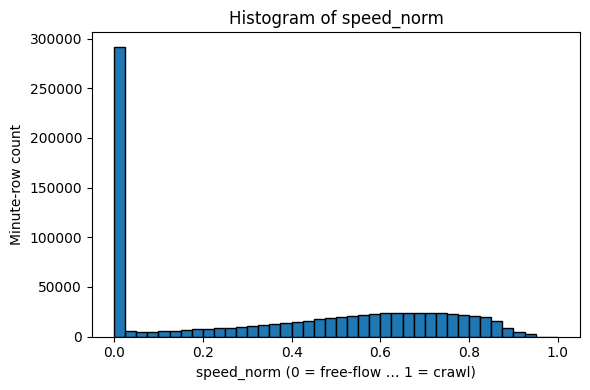

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df["speed_norm"].plot(kind="hist", bins=40, edgecolor="black")
plt.title("Histogram of speed_norm")
plt.xlabel("speed_norm (0 = free-flow … 1 = crawl)")
plt.ylabel("Minute-row count")
plt.tight_layout()
plt.show()


In [45]:
route_stats = (df.groupby("route_id")["speed_norm"]
                 .agg(["mean","median","quantile"])
                 .rename(columns={"quantile":"75pct"})
                 .sort_values("mean", ascending=False))

route_stats.head(10)        # worst 10 routes by average speed_norm


,mean,median,75pct
route_id,,,
4700_100876,0.523602,0.618321,0.618321
4700_100865,0.491008,0.588841,0.588841
4700_100882,0.487266,0.567274,0.567274
4710_102538,0.481486,0.604019,0.604019
4703_101180,0.479488,0.564174,0.564174
4700_100877,0.467867,0.559274,0.559274
4703_101179,0.467463,0.560356,0.560356
4702_101137,0.464565,0.537761,0.537761
4700_100867,0.461951,0.502866,0.502866


In [48]:
probe = df.sample(5, random_state=1)[
            ["route_id","direction_id","speed_kph","free_kph","speed_norm","delay_norm"]]
probe


,route_id,direction_id,speed_kph,free_kph,speed_norm,delay_norm
317169,4702_101116,0,13.295762,43.029887,0.691011,0.127
564170,4702_101054,0,14.626186,43.459727,0.663454,0.244
308293,4702_101043,0,8.406257,38.409232,0.781140,0.376
114815,4702_101049,1,19.685999,35.592775,0.446910,0.000
801387,4702_101098,0,24.796089,31.073760,0.202025,0.000


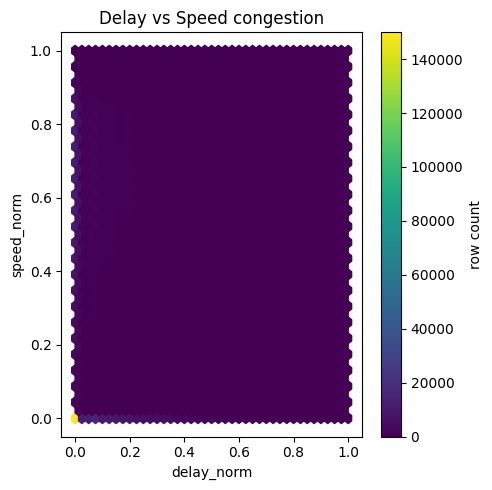

In [47]:
plt.figure(figsize=(5,5))
plt.hexbin(df["delay_norm"], df["speed_norm"], gridsize=40,
           extent=[0,1,0,1], cmap="viridis")
plt.xlabel("delay_norm")
plt.ylabel("speed_norm")
plt.title("Delay vs Speed congestion")
plt.colorbar(label="row count")
plt.tight_layout()
plt.show()


In [49]:
print("NaNs in speed_norm :", df["speed_norm"].isna().mean().round(4))
print("NaNs in free_kph   :", df["free_kph"].isna().mean().round(4))


NaNs in speed_norm : 0.0
NaNs in free_kph   : 0.0


In [56]:
df_delay_norm_14["temp_c"][df_delay_norm_14["temp_c"]>20.2]

490       20.6
491       20.6
492       20.6
493       20.6
494       20.6
          ... 
826526    20.6
826527    20.6
826528    20.6
826529    20.6
826530    20.6
Name: temp_c, Length: 29213, dtype: float64

# Added multiple norms - Currently added Weather Norm. Let's Check?

In [57]:
df = pd.read_parquet(
    "../data_hist/2025-07-14/norms/veh_minute_dsw.parquet",
    columns=["temp_c","heat_norm","cold_norm","rain_norm"]
)
print(df[df["temp_c"] > 18][["temp_c","heat_norm"]].head())
print(df["heat_norm"].describe())


    temp_c  heat_norm
15    18.4       0.04
16    18.4       0.04
17    18.4       0.04
18    18.4       0.04
19    18.4       0.04
count    827334.000000
mean          0.045078
std           0.072099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.070000
max           0.353333
Name: heat_norm, dtype: float64


# AAAAAnd Finally the stress score I just implemented! This is BIG! Let's Check 

In [7]:
import pandas as pd
df = pd.read_parquet("../data_hist/2025-07-14/norms/veh_minute_scored.parquet")
print(df["row_stress"].describe())
print("max should be ≤ 1.0 :", df["row_stress"].max())


count    827334.000000
mean          0.159882
std           0.119712
min           0.000000
25%           0.046788
50%           0.163787
75%           0.242954
max           0.776539
Name: row_stress, dtype: float64
max should be ≤ 1.0 : 0.7765390092161449


In [8]:
df

,vehicle_id,trip_id,route_id,direction_id,timestamp,datetime_utc,lat,lon,speed_kph,delay_sec,...,gap_forward_sec,vanish_anchor,vanished,delay_norm,free_kph,speed_norm,rain_norm,heat_norm,cold_norm,row_stress
0,1,4700_745,4700_100865,0,1752506581,2025-07-14 15:23:01+00:00,53.350243,-6.250592,0.054333,180.0,...,58.0,False,False,0.18,84.880629,0.000000,0.0,0.0,0.0,0.072000
1,1,4700_745,4700_100865,0,1752506639,2025-07-14 15:23:59+00:00,53.349335,-6.251461,7.216326,180.0,...,62.0,False,False,0.18,84.880629,0.914983,0.0,0.0,0.0,0.346495
2,1,4700_745,4700_100865,0,1752506701,2025-07-14 15:25:01+00:00,53.347328,-6.252004,13.123150,180.0,...,64.0,False,False,0.18,84.880629,0.845393,0.0,0.0,0.0,0.325618
3,1,4700_745,4700_100865,0,1752506765,2025-07-14 15:26:05+00:00,53.347397,-6.253308,4.886600,180.0,...,66.0,False,False,0.18,84.880629,0.000000,0.0,0.0,0.0,0.072000
4,1,4700_745,4700_100865,0,1752506831,2025-07-14 15:27:11+00:00,53.347397,-6.254719,5.108637,180.0,...,53.0,False,False,0.18,84.880629,0.939814,0.0,0.0,0.0,0.353944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827329,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,0.0,False,False,0.00,57.553242,0.000000,0.0,0.0,0.0,0.000000
827330,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,0.0,False,False,0.00,57.553242,0.000000,0.0,0.0,0.0,0.000000
827331,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,0.0,False,False,0.00,57.553242,0.000000,0.0,0.0,0.0,0.000000
827332,6736,4707_19957,4702_101106,1,1752478000,2025-07-14 07:26:40+00:00,53.305016,-6.216809,0.000000,-1070.0,...,0.0,False,False,0.00,57.553242,0.000000,0.0,0.0,0.0,0.000000


In [46]:
df[df["row_stress"]>0.4]

,vehicle_id,trip_id,route_id,direction_id,timestamp,datetime_utc,lat,lon,speed_kph,delay_sec,...,gap_forward_sec,vanish_anchor,vanished,delay_norm,free_kph,speed_norm,rain_norm,heat_norm,cold_norm,row_stress
586,3,4700_402,4700_100868,0,1752501542,2025-07-14 13:59:02+00:00,53.290894,-6.686123,5.971373,484.0,...,70.0,False,False,0.422667,74.713253,0.920076,0.0,0.10,0.0,0.453090
587,3,4700_402,4700_100868,0,1752501612,2025-07-14 14:00:12+00:00,53.290569,-6.687969,6.578039,484.0,...,61.0,False,False,0.422667,74.713253,0.911956,0.0,0.10,0.0,0.450654
601,3,4700_402,4700_100868,0,1752502507,2025-07-14 14:15:07+00:00,53.265717,-6.822430,32.193204,3201.0,...,61.0,False,False,0.955667,74.713253,0.569110,0.0,0.04,0.0,0.556200
602,3,4700_402,4700_100868,0,1752502568,2025-07-14 14:16:08+00:00,53.263451,-6.830576,35.261450,3201.0,...,61.0,False,False,0.955667,74.713253,0.528043,0.0,0.04,0.0,0.543880
603,3,4700_402,4700_100868,0,1752502629,2025-07-14 14:17:09+00:00,53.258595,-6.835898,38.104537,3201.0,...,61.0,False,False,0.955667,74.713253,0.489990,0.0,0.04,0.0,0.532464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824348,6732,4707_11064,4702_101071,0,1752472703,2025-07-14 05:58:23+00:00,53.311520,-6.300610,7.519032,475.0,...,60.0,False,False,0.416667,36.241395,0.792529,0.0,0.00,0.0,0.404425
824366,6732,4707_11064,4702_101071,0,1752473772,2025-07-14 06:16:12+00:00,53.288181,-6.357144,6.964555,563.0,...,80.0,False,False,0.475333,36.241395,0.807829,0.0,0.00,0.0,0.432482
824372,6732,4707_11064,4702_101071,0,1752474137,2025-07-14 06:22:17+00:00,53.286526,-6.375034,8.315693,563.0,...,56.0,False,False,0.475333,36.241395,0.770547,0.0,0.00,0.0,0.421297
824375,6732,4707_11064,4702_101071,0,1752474313,2025-07-14 06:25:13+00:00,53.283180,-6.384817,6.412058,563.0,...,60.0,False,False,0.475333,36.241395,0.823074,0.0,0.00,0.0,0.437055


In [37]:
len(df["trip_id"][df["row_stress"]>0.7].unique())

6

In [38]:
len(df["vehicle_id"][df["row_stress"]>0.7].unique())

5

In [42]:
print(df["vanished"].value_counts())


vanished
False    815544
True      11790
Name: count, dtype: int64


<Axes: title={'center': 'Max stress by hour'}, xlabel='hour'>

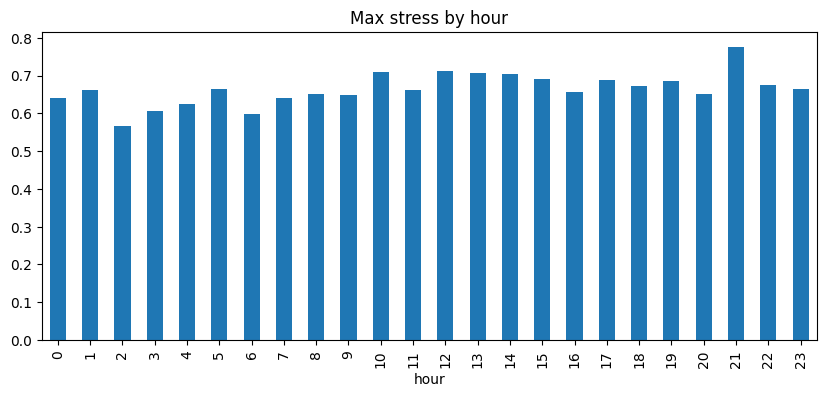

In [49]:
df["hour"] = pd.to_datetime(df["datetime_ie"]).dt.hour   # quick hour bucket
hourly = (df.groupby("hour")["row_stress"]
            .max()
            .reindex(range(24)))          # 00→23

hourly.plot(kind="bar", figsize=(10,4), title="Max stress by hour")

In [6]:
import pandas as pd

PATH = "../data_hist/2025-07-14/norms/veh_minute_scored.parquet"

cols = ["route_id", "direction_id", "zone",
        "datetime_ie",               # local dt column
        "row_stress",
        "delay_norm", "speed_norm",
        "rain_norm", "heat_norm", "cold_norm",
        "vanished"]

df = pd.read_parquet(PATH, columns=cols)
df["hour"] = pd.to_datetime(df["datetime_ie"]).dt.hour   # quick hour bucket
print(f"{len(df):,} rows loaded")
df.head()


827,334 rows loaded


,route_id,direction_id,zone,datetime_ie,row_stress,delay_norm,speed_norm,rain_norm,heat_norm,cold_norm,vanished,hour
0,4700_100865,0,centre,2025-07-14 16:23:01,0.072000,0.18,0.000000,0.0,0.0,0.0,False,16
1,4700_100865,0,centre,2025-07-14 16:23:59,0.346495,0.18,0.914983,0.0,0.0,0.0,False,16
2,4700_100865,0,centre,2025-07-14 16:25:01,0.325618,0.18,0.845393,0.0,0.0,0.0,False,16
3,4700_100865,0,centre,2025-07-14 16:26:05,0.072000,0.18,0.000000,0.0,0.0,0.0,False,16
4,4700_100865,0,centre,2025-07-14 16:27:11,0.353944,0.18,0.939814,0.0,0.0,0.0,False,16


count    827334.000000
mean          0.159882
std           0.119712
min           0.000000
25%           0.046788
50%           0.163787
75%           0.242954
max           0.776539
Name: row_stress, dtype: float64


<Axes: title={'center': 'Histogram of row_stress'}, ylabel='Frequency'>

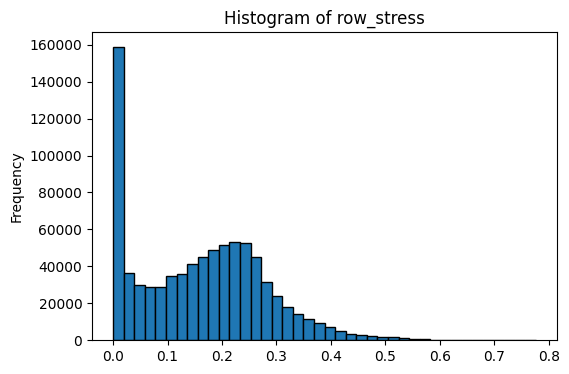

In [63]:
print(df["row_stress"].describe())
df["row_stress"].plot(kind="hist", bins=40, edgecolor="black",
                      title="Histogram of row_stress", figsize=(6,4))


In [66]:
df["row_stress"][df["row_stress"]>0.7]

449601    0.700312
449603    0.707987
449605    0.700719
449609    0.705043
449610    0.700361
449612    0.703070
472180    0.702664
478508    0.776539
478840    0.759227
478841    0.748933
478842    0.749139
478843    0.733337
478844    0.705764
478863    0.725109
478864    0.701515
478867    0.764535
478869    0.745585
483258    0.709388
667326    0.707683
667330    0.712621
667354    0.700338
Name: row_stress, dtype: float64

In [67]:
top1 = df.nlargest(int(0.01*len(df)), "row_stress")
print(top1[["row_stress","delay_norm","speed_norm",
            "rain_norm","heat_norm","vanished"]].head(10))


        row_stress  delay_norm  speed_norm  rain_norm  heat_norm  vanished
478508    0.776539    1.000000    0.921797        0.0       0.00      True
478867    0.764535    1.000000    0.881783        0.0       0.00      True
478840    0.759227    1.000000    0.864089        0.0       0.00      True
478842    0.749139    1.000000    0.830464        0.0       0.00      True
478841    0.748933    1.000000    0.829777        0.0       0.00      True
478869    0.745585    1.000000    0.818616        0.0       0.00      True
478843    0.733337    1.000000    0.777791        0.0       0.00      True
478863    0.725109    1.000000    0.750364        0.0       0.00      True
667330    0.712621    0.812333    0.918959        0.0       0.15      True
483258    0.709388    0.813444    0.917367        0.0       0.11      True


In [68]:
route_s = (df.groupby("route_id")["row_stress"]
             .mean()
             .sort_values(ascending=False)
             .head(15))
route_s


route_id
4700_100882    0.271439
4710_102335    0.264543
4703_101163    0.254173
4710_102351    0.252648
4710_102358    0.247507
4700_100868    0.246265
4703_101158    0.245749
4710_102330    0.239051
4703_101180    0.239025
4700_100875    0.228652
4710_102509    0.227706
4702_101137    0.227268
4700_100871    0.223845
4702_101052    0.222293
4703_101166    0.216838
Name: row_stress, dtype: float64

<Axes: title={'center': 'Average stress by hour'}, xlabel='hour'>

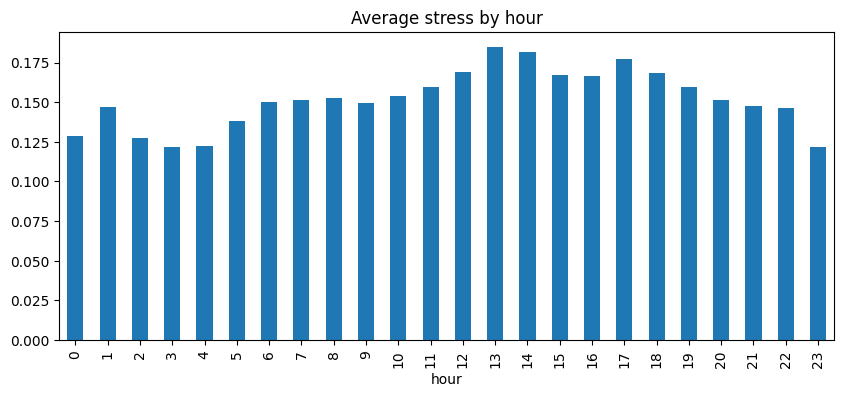

In [69]:
hourly = (df.groupby("hour")["row_stress"]
            .mean()
            .reindex(range(24)))          # 00→23

hourly.plot(kind="bar", figsize=(10,4), title="Average stress by hour")


In [70]:
print(df[["row_stress","delay_norm","speed_norm",
          "rain_norm","heat_norm"]].corr()["row_stress"])


row_stress    1.000000
delay_norm    0.589656
speed_norm    0.810462
rain_norm          NaN
heat_norm     0.076574
Name: row_stress, dtype: float64


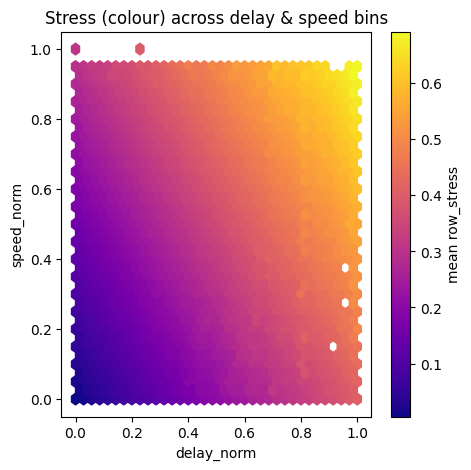

In [72]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(5,5))
plt.hexbin(df["delay_norm"], df["speed_norm"],
           C=df["row_stress"], reduce_C_function=np.mean,
           gridsize=35, cmap="plasma", extent=[0,1,0,1])
plt.xlabel("delay_norm")
plt.ylabel("speed_norm")
plt.title("Stress (colour) across delay & speed bins")
cbar = plt.colorbar()
cbar.set_label("mean row_stress")
plt.show()
